In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [2]:
!pip install wordcloud

In [3]:
!pip install kmeanstf

In [4]:
import numpy as np
import pandas as pd
import pickle
import csv
from matplotlib import pyplot as plt
import plotly.express as px

#-- Text utils
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec as w2v

import os
import string
import collections
from collections import Counter
import re
import seaborn as sns

#-- Sklearn Package
from sklearn.feature_selection import SelectKBest, chi2          #feature selection
from sklearn.feature_extraction.text import CountVectorizer      #-- Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer      #-- Tf-Idf
from sklearn.decomposition import PCA                            #-- PCA
from sklearn.decomposition import TruncatedSVD                   #-- SVD
from sklearn.svm import SVC                                      #-- SVM
from sklearn.model_selection import train_test_split             #-- Split Dataset
from sklearn.metrics import classification_report                #-- Model Summary 
from sklearn.cluster import KMeans                               #-- K-means Algorithm
from sklearn.metrics import confusion_matrix                     #-- Confusion Matrix                             
from sklearn.cluster import AgglomerativeClustering              #-- Hierarchical
from sklearn.neighbors import KNeighborsClassifier               #-- knn
from sklearn.preprocessing import StandardScaler                 #-- Standard
from xgboost import XGBClassifier                                #-- XGBoost
from sklearn.ensemble import RandomForestClassifier              #-- Random Forest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

#-- Cluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.metrics.cluster import normalized_mutual_info_score #-- Mutual Information Score

#-- Neural Network utilities
from sklearn.neural_network import MLPClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics

#-- visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
from yellowbrick.cluster.elbow import kelbow_visualizer
from kmeanstf import KMeansTF
import time
import plotly.express as px
from yellowbrick.cluster import KElbowVisualizer

In [5]:
# Download stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Import data

In [6]:
train = pd.read_csv('/content/drive/MyDrive/Progetto TEXTMINING/drugLib_raw/drugLibTrain_raw.tsv',sep='\t')
train.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [7]:
train['sideEffectsReview'][0]

'cough, hypotension , proteinuria, impotence , renal failure , angina pectoris , tachycardia , eosinophilic pneumonitis, tastes disturbances , anusease anorecia , weakness fatigue insominca weakness'

In [8]:
test = pd.read_csv('/content/drive/MyDrive/Progetto TEXTMINING/drugLib_raw/drugLibTest_raw.tsv', sep='\t')
test.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,1366,biaxin,9,Considerably Effective,Mild Side Effects,sinus infection,The antibiotic may have destroyed bacteria cau...,"Some back pain, some nauseau.",Took the antibiotics for 14 days. Sinus infect...
1,3724,lamictal,9,Highly Effective,Mild Side Effects,bipolar disorder,Lamictal stabilized my serious mood swings. On...,"Drowsiness, a bit of mental numbness. If you t...",Severe mood swings between hypomania and depre...
2,3824,depakene,4,Moderately Effective,Severe Side Effects,bipolar disorder,Initial benefits were comparable to the brand ...,"Depakene has a very thin coating, which caused...",Depakote was prescribed to me by a Kaiser psyc...
3,969,sarafem,10,Highly Effective,No Side Effects,bi-polar / anxiety,It controlls my mood swings. It helps me think...,I didnt really notice any side effects.,This drug may not be for everyone but its wond...
4,696,accutane,10,Highly Effective,Mild Side Effects,nodular acne,Within one week of treatment superficial acne ...,Side effects included moderate to severe dry s...,Drug was taken in gelatin tablet at 0.5 mg per...


Si accorpano train e test, in prossimità della classificazione si provvede a risplittare in modo casuale il dataset

In [9]:
raw_data=train.append(test,ignore_index=True)
raw_data.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


# Data Exploration

In [10]:
raw_data.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [11]:
print(raw_data.shape)
print(raw_data.columns)

(4143, 9)
Index(['Unnamed: 0', 'urlDrugName', 'rating', 'effectiveness', 'sideEffects',
       'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview'],
      dtype='object')


In [12]:
#raw_data.rename(columns={'Unnamed: 0':'id'}, inplace=True)
data = raw_data.copy(True)
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.head()

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [13]:
# Remove duplicates
data = data.drop_duplicates()
print('Original dataframe rows: ' + str(raw_data.shape[0]) + '\n' +
      'New dataframe rows: ' + str(data.shape[0]) + '\n' +
      'Num duplicates: ' + str(raw_data.shape[0]-data.shape[0]))

Original dataframe rows: 4143
New dataframe rows: 4093
Num duplicates: 50


In [14]:
data.isnull().sum()

urlDrugName          0
rating               0
effectiveness        0
sideEffects          0
condition            1
benefitsReview       0
sideEffectsReview    2
commentsReview       8
dtype: int64

In [15]:
data.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Recoding rating to 3 classes

In [16]:
#data["rating"]
data['rating_copia'] = data["rating"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
data = data.astype({"rating": str})
data["rating"].replace({"1":"low","2":"low","3":"low","4":"low","5":"medium","6":"medium","7":"medium","8":"medium", "9":"high","10":"high"}, inplace=True)
data['rating'] = pd.Categorical(data['rating'], ["low","medium","high"])
data['rating']

0          low
1          low
2         high
3          low
4          low
         ...  
4138    medium
4139      high
4140    medium
4141      high
4142    medium
Name: rating, Length: 4082, dtype: category
Categories (3, object): ['low', 'medium', 'high']

In [18]:
rat_grp=data.groupby('rating').size()

In [19]:
rat_grp.index

CategoricalIndex(['low', 'medium', 'high'], categories=['low', 'medium', 'high'], ordered=False, dtype='category', name='rating')

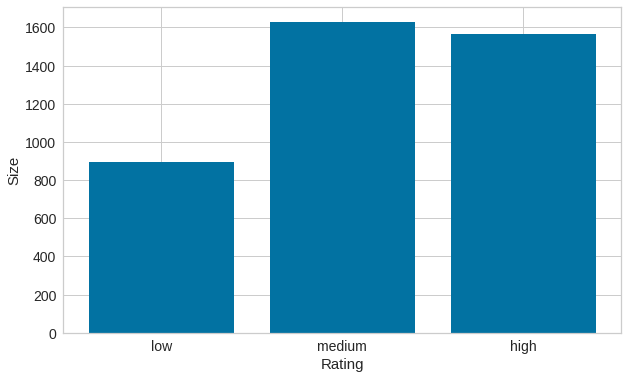

In [20]:
plt.figure(figsize = (10, 6))
plt.bar(rat_grp.index, 
        rat_grp.values)
plt.xlabel("Rating", size = 15)
plt.ylabel("Size", size = 15)
#plt.title()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [21]:
data['effectiveness'] = pd.Categorical(data['effectiveness'], ["Ineffective","Marginally Effective","Moderately Effective","Considerably Effective","Highly Effective"])

In [22]:
eff_grp=data.groupby('effectiveness').size()

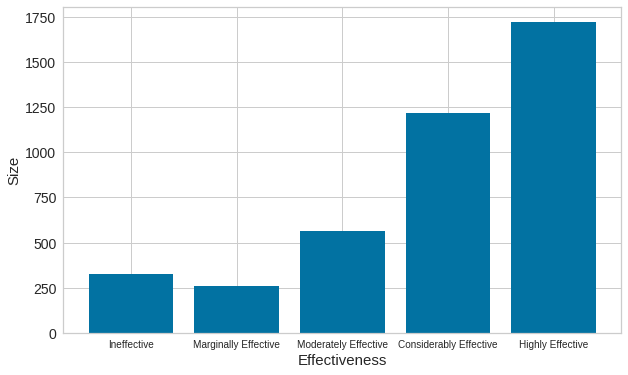

In [23]:
plt.figure(figsize = (10, 6))
plt.bar(eff_grp.index, 
        eff_grp.values)
plt.xlabel("Effectiveness", size = 15)
plt.ylabel("Size", size = 15)
#plt.title()
plt.xticks(fontsize=10)
plt.yticks(fontsize=14)
plt.show()

In [24]:
data['sideEffects_copia'] = data['sideEffects']

In [25]:
data['sideEffects'] = pd.Categorical(data['sideEffects'], ["No Side Effects", "Mild Side Effects", "Moderate Side Effects", "Severe Side Effects", "Extremely Severe Side Effects"])

In [26]:
data["sideEffects"].replace({"No Side Effects":"No Side Effects","Mild Side Effects":"Mild/moderate Side Effects","Moderate Side Effects":"Mild/moderate Side Effects","Severe Side Effects":"Severe Side Effects","Extremely Severe Side Effects":"Severe Side Effects"}, inplace=True)
data['sideEffects'] = pd.Categorical(data['sideEffects'], ["No Side Effects","Mild/moderate Side Effects","Severe Side Effects"])
data['sideEffects']

0       Mild/moderate Side Effects
1              Severe Side Effects
2                  No Side Effects
3       Mild/moderate Side Effects
4              Severe Side Effects
                   ...            
4138           Severe Side Effects
4139               No Side Effects
4140    Mild/moderate Side Effects
4141               No Side Effects
4142    Mild/moderate Side Effects
Name: sideEffects, Length: 4082, dtype: category
Categories (3, object): ['No Side Effects', 'Mild/moderate Side Effects', 'Severe Side Effects']

In [27]:
side_grp=data.groupby('sideEffects').size()

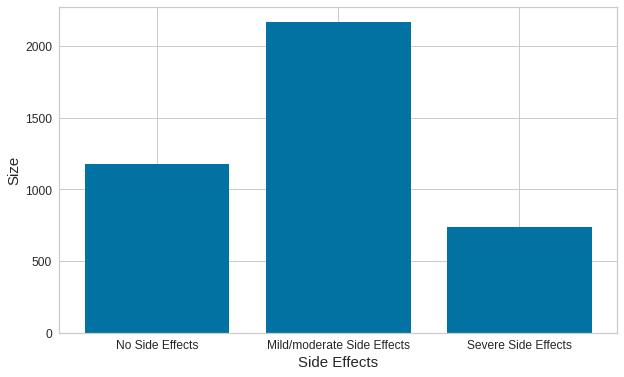

In [28]:
plt.figure(figsize = (10, 6))
plt.bar(side_grp.index, 
        side_grp.values)
plt.xlabel("Side Effects", size = 15)
plt.ylabel("Size", size = 15)
#plt.title()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [29]:
len(data['urlDrugName'].unique())

540

In [30]:
pharma=data.groupby('urlDrugName').size().sort_values(ascending=False)

In [31]:
pharma=pd.DataFrame(pharma)
pharma[pharma[0]>20]

,0
urlDrugName,
lexapro,71
paxil,58
synthroid,52
retin-a,52
zoloft,52
prozac,51
effexor,46
effexor-xr,46
accutane,44


# Consegna
* Text pre-processing (mandatory):
1. Tokenization;
2. Normalization;
3. Stemming/Lemmatization;
4. Stop-words removal;
5. Additional pre-processing operations can be implemented.

* Text representation
1. Choose suitable representation(s) and explain the rationale behind
this choice.

* “Core” tasks (please select TWO at your choice):
1. Text classification (e.g., with respect to different topics);
2. Text clustering;
3. Topic modeling;
4. Text summarization.

* The above-mentioned tasks must be performed on
suitable datasets.

# Pre-processing

In [32]:
def preprocessing(doc_text):
    tokenized = []                                                   #-- List for Tokenization
    tokenized_no_stopwords = []                                      #-- List for Tokenization not a Stopword
    lemmed = []                                                      #-- List of Lemmatized Words
    stemmed = []                                                     #-- List of Stemmed Words
    
    doc_text = doc_text.str.lower()                                  #-- Lower Case

    for phrase in doc_text:
        phrase = re.sub(r"won't", "will not", phrase)                #-- Decontract phrase
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)

        phrase = re.sub(r"http\S+", '', phrase)                      #-- Remove URLS

        phrase = phrase.translate(str.maketrans('', '',
                                                string.punctuation)) #-- Remove Punctuation
        phrase = re.sub("\S*\d\S*", "", phrase).strip()              #-- Remove words with number
        phrase = re.sub(r'\d+', '', phrase)                          #-- Remove Blankspace

        phrase = WordPunctTokenizer().tokenize(phrase)               #-- Tokenization
        tokenized.append(phrase)                                     #-- Add to Tokenization List
    
    stop = nltk.corpus.stopwords.words('english')                    #-- Remove stopwords
    
    for phrase in tokenized:
        temp = []                                                    #-- Temporary File for a Single Sentence
        for token in phrase:
            if token not in stop:                                    #-- If the Token is a Stopword
                temp.append(token)                                   #-- Add to Temp List
        tokenized_no_stopwords.append(temp)                          #-- Otherwise is not a Stopword
            
    #-- Stemming and Lemmatization
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    for phrase in tokenized_no_stopwords:
        temp_stem = []
        temp_lem = []

        for word in phrase:
            temp_stem.append(stemmer.stem(word))
            temp_lem.append(lemmatizer.lemmatize(word))
        stemmed.append(temp_stem)
        lemmed.append(temp_lem)
    
    return (stemmed,                                                  #-- Stemmed List
            lemmed)                                                   #-- Lemmed List

In [33]:
reviews=data['sideEffectsReview']

*   Lower Case
*   Decontraction phrases
*   Remove URLS
*   Remove punctuation
*   Remove numbers
*   Remove blankspace
*   Tokenization
*   Remove Stopwords
*   Lemmatization
*   Stemming

In [34]:
text = preprocessing(reviews)

In [35]:
text_stemmed = text[0]
text_lemmed = text[1]

In [36]:
reviews[0]

'cough, hypotension , proteinuria, impotence , renal failure , angina pectoris , tachycardia , eosinophilic pneumonitis, tastes disturbances , anusease anorecia , weakness fatigue insominca weakness'

In [37]:
print(text_stemmed[0],'\n', text_lemmed[0])

['cough', 'hypotens', 'proteinuria', 'impot', 'renal', 'failur', 'angina', 'pectori', 'tachycardia', 'eosinophil', 'pneumon', 'tast', 'disturb', 'anuseas', 'anorecia', 'weak', 'fatigu', 'insominca', 'weak'] 
 ['cough', 'hypotension', 'proteinuria', 'impotence', 'renal', 'failure', 'angina', 'pectoris', 'tachycardia', 'eosinophilic', 'pneumonitis', 'taste', 'disturbance', 'anusease', 'anorecia', 'weakness', 'fatigue', 'insominca', 'weakness']


# Text representation

It is necessary to trasform the list of tokens of a sentence in a single list.

In [38]:
# From token to phrase function
def token_to_phrase(token_list):
    phrase_list = []
    
    for phrase in token_list:
        seq = ""
        for word in phrase:
            seq = seq + " " + word                                              #-- Add a Blankspace
        phrase_list.append(seq)                                                 #-- Attach each Token in a Phrase
    return phrase_list

In [39]:
text_stemmed_preprocessed = token_to_phrase(token_list = text_stemmed)
text_lemmed_preprocessed  = token_to_phrase(token_list = text_lemmed)

In [40]:
text_stemmed_preprocessed[0]

' cough hypotens proteinuria impot renal failur angina pectori tachycardia eosinophil pneumon tast disturb anuseas anorecia weak fatigu insominca weak'

In [41]:
text_lemmed_preprocessed[0]

' cough hypotension proteinuria impotence renal failure angina pectoris tachycardia eosinophilic pneumonitis taste disturbance anusease anorecia weakness fatigue insominca weakness'

## Bag of words

In [46]:
#vectorizer = CountVectorizer(min_df=5, max_df=95)
vectorizer = CountVectorizer(max_features=1500)
X_stemmed_bow =  vectorizer.fit_transform(text_stemmed_preprocessed)
X_lemmed_bow = vectorizer.fit_transform(text_lemmed_preprocessed)

print(X_lemmed_bow.shape)
print(X_stemmed_bow.shape)

#vectorizer = CountVectorizer(min_df=5, max_df=95,ngram_range=(1,2))

#X_stemmed_bow2 =  vectorizer.fit_transform(text_stemmed_preprocessed)
#X_lemmed_bow2 = vectorizer.fit_transform(text_lemmed_preprocessed)

#print(X_lemmed_bow2.shape)
#print(X_stemmed_bow2.shape)

(4082, 1500)
(4082, 1500)


## Binary

In [47]:
#vectorizer = CountVectorizer(binary = True, min_df=5, max_df=95)
vectorizer = CountVectorizer(binary = True, max_features=1500)
X_stemmed_binary =  vectorizer.fit_transform(text_stemmed_preprocessed)
X_lemmed_binary = vectorizer.fit_transform(text_lemmed_preprocessed)

print(X_lemmed_binary.shape)
print(X_stemmed_binary.shape)

#vectorizer = CountVectorizer(binary = True, ngram_range=(1,2), min_df=5, max_df=95)

#X_stemmed_binary2 =  vectorizer.fit_transform(text_stemmed_preprocessed)
#X_lemmed_binary2 = vectorizer.fit_transform(text_lemmed_preprocessed)

#print(X_lemmed_binary2.shape)
#print(X_stemmed_binary2.shape)

(4082, 1500)
(4082, 1500)


## TF-IDF

In [48]:
#vectorizer = TfidfVectorizer(min_df=5, max_df=95)                                                                       
vectorizer = TfidfVectorizer(max_features=1500)                                                                       
X_stemmed_tfidf = vectorizer.fit_transform(text_stemmed_preprocessed)
X_lemmed_tfidf = vectorizer.fit_transform(text_lemmed_preprocessed)
print(X_lemmed_tfidf.shape)
print(X_stemmed_tfidf.shape)

#vectorizer = TfidfVectorizer(min_df=5, max_df=95, ngram_range=(1,2))                                                                       
                                                                                                     
#X_stemmed_tfidf2 = vectorizer.fit_transform(text_stemmed_preprocessed)
#X_lemmed_tfidf2 = vectorizer.fit_transform(text_lemmed_preprocessed)
#print(X_lemmed_tfidf2.shape)
#print(X_stemmed_tfidf2.shape)

(4082, 1500)
(4082, 1500)


## Dataset list

In [49]:
dataset_list = [X_stemmed_bow, X_lemmed_bow,
                X_stemmed_binary, X_lemmed_binary,
                X_stemmed_tfidf, X_lemmed_tfidf]
                #X_stemmed_bow2, X_lemmed_bow2,
                #X_stemmed_binary2, X_lemmed_binary2,
                #X_stemmed_tfidf2, X_lemmed_tfidf2]

dataset_names = ['X_stemmed_bow', 'X_lemmed_bow',
                 'X_stemmed_binary', 'X_lemmed_binary',
                 'X_stemmed_tfidf', 'X_lemmed_tfidf']
                 #'X_stemmed_bow2', 'X_lemmed_bow2',
                 #'X_stemmed_binary2', 'X_lemmed_binary2',
                 #'X_stemmed_tfidf2', 'X_lemmed_tfidf2']

# Classification

## Side Effects

In [ ]:
score=data['sideEffects']
CV = 5

### SVM

In [ ]:
classifier_list_svm = []

for i in range(len(dataset_list)):
  clf = LinearSVC().fit(X_train, y_train) #-- SVM
  y_pred = clf.predict(X_test)      #-- Prediction

  print(dataset_names[i])                      #-- Print Single Dataset
  #print(classification_report(y_test, y_pred)) #-- Model Summary
  print(np.mean(cross_val_score(clf, dataset_list[i], score, scoring='accuracy', cv=CV)))
  classifier_list_svm.append(clf)

X_stemmed_bow
0.6942622459020329
X_lemmed_bow
0.6972007223942209
X_stemmed_binary
0.7008723930208559
X_lemmed_binary
0.6957340341277269
X_stemmed_tfidf
0.721701526387789
X_lemmed_tfidf
0.7243949048407612


### KNN

In [ ]:
classifier_list_knn = []

for i in range(len(dataset_list)):
  knn = KNeighborsClassifier(n_neighbors = 5,
                             n_jobs = -1).fit(X_train, y_train) #-- kNN
  y_pred = knn.predict(X_test)                                  #-- Prediction

  print(dataset_names[i])                      #-- Print Single Dataset
  #print(classification_report(y_test, y_pred)) #-- Model Summary
  print(np.mean(cross_val_score(knn, dataset_list[i], score, scoring='accuracy', cv=CV)))

  classifier_list_knn.append(knn)

X_stemmed_bow
0.6166111671106631
X_lemmed_bow
0.6185704514363886
X_stemmed_binary
0.5908914728682171
X_lemmed_binary
0.5904033767729858
X_stemmed_tfidf
0.5475418196654427
X_lemmed_tfidf
0.544109847121223


### Random forest

In [ ]:
classifier_list_rf = []

for i in range(len(dataset_list)):
  rf = RandomForestClassifier(n_jobs = -1).fit(X_train, y_train) #-- Random Forest
  y_pred = rf.predict(X_test)                                    #-- Prediction

  print(dataset_names[i])                      #-- Print Single Dataset
  #print(classification_report(y_test, y_pred)) #-- Model Summary
  print(np.mean(cross_val_score(rf, dataset_list[i], score, scoring='accuracy', cv=CV)))
  classifier_list_rf.append(rf)

X_stemmed_bow
0.736156310749514
X_lemmed_bow
0.7319920440636475
X_stemmed_binary
0.7373812009503925
X_lemmed_binary
0.7339513283893729
X_stemmed_tfidf
0.7292998656010752
X_lemmed_tfidf
0.7275820793433653


### MLP

In [ ]:
classifier_list_mlp = []

for i in range(len(dataset_list)):
  mlp = MLPClassifier(hidden_layer_sizes=(100,50,50,50), 
                      activation='relu',
                      solver='adam',
                      max_iter=500)
  
  print(dataset_names[i])                      #-- Print Single Dataset
  #print(classification_report(y_test, y_pred)) #-- Model Summary
  print(np.mean(cross_val_score(mlp, dataset_list[i], score, scoring='accuracy', cv=CV)))

X_stemmed_bow
0.7153319773441812
X_lemmed_bow
0.7084707322341421
X_stemmed_binary
0.7128818969448245
X_lemmed_binary
0.7096929224566203
X_stemmed_tfidf
0.7028367773057815
X_lemmed_tfidf
0.6910759713922289


## Lemmed TFIDF dimensionality reduction 

In [ ]:
start = time.time()
#Creating a tf-idf representation of unigram and bigram
tf_idf_vector = TfidfVectorizer(sublinear_tf=True)
#Using the tf-idf with the preprocessed dataset
tf_idf_Matrix = tf_idf_vector.fit_transform(text_lemmed_preprocessed)
features_tf = tf_idf_vector.get_feature_names()
#Conversion to array
tf_idf_Matrix = tf_idf_Matrix.toarray()
feature_array = np.array(features_tf)
#Conversion to DataFrame
tf_idf_array = pd.DataFrame(tf_idf_Matrix, columns = feature_array)
tf_idf_array.head()

end = time.time()
print("TF-IDF dimensions: ", tf_idf_Matrix.shape)
print('Execution time:',(end-start), 'seconds')

TF-IDF dimensions:  (4082, 7666)
Execution time: 0.2677898406982422 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
start = time.time()
#Creating a tf-idf representation of unigram and bigram
tf_idf_vector = CountVectorizer(binary = True)
#Using the tf-idf with the preprocessed dataset
tf_idf_Matrix = tf_idf_vector.fit_transform(text_lemmed_preprocessed)
features_tf = tf_idf_vector.get_feature_names()
#Conversion to array
tf_idf_Matrix = tf_idf_Matrix.toarray()
feature_array = np.array(features_tf)
#Conversion to DataFrame
tf_idf_array = pd.DataFrame(tf_idf_Matrix, columns = feature_array)
tf_idf_array.head()

end = time.time()
print("TF-IDF dimensions: ", tf_idf_Matrix.shape)
print('Execution time:',(end-start), 'seconds')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF dimensions:  (4082, 7666)
Execution time: 0.35926079750061035 seconds


In [ ]:
#reset indexes
y = data['sideEffects']
y = y.reset_index()
y = y['sideEffects']

In [ ]:
#FEATURE SELECTION
start = time.time()
#Maintaining only 80% of best features according to chi2 independence test
k = int(tf_idf_Matrix.shape[1]*0.80) 
sel_chi2 = SelectKBest(chi2, k=k)
# saving matrix
tf_idf_reduced = sel_chi2.fit_transform(tf_idf_Matrix, y)
print('TF-IDF matrix reduced dim:',tf_idf_reduced.shape)

end = time.time()
print('Execution time:',(end-start), 'seconds')

TF-IDF matrix reduced dim: (4082, 6132)
Execution time: 1.7851932048797607 seconds


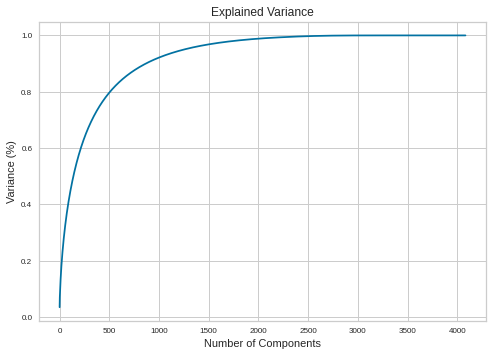

Execution time: 84.4112286567688 seconds


In [ ]:
#FEATURE SYNTHETIZATION
start = time.time()
pca = PCA()
pca.fit(tf_idf_reduced)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

end = time.time()
print('Execution time:',(end-start), 'seconds')

In [ ]:
#maintaining only 1000 components that can explain 80% of the tot variance
pca = PCA(n_components = 1000)
matrix_reduced = pca.fit_transform(tf_idf_reduced)
end = time.time()
print('Execution time:',(end-start), 'seconds')
print('PCA matrix reduced dim:',matrix_reduced.shape)

Execution time: 263.6569962501526 seconds
PCA matrix reduced dim: (4082, 1000)


In [ ]:
#Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(matrix_reduced,y, test_size=0.1,
                                                    random_state = 123)
print('Train examples:', X_train.shape[0])
print('Test examples:', X_test.shape[0])

Train examples: 3673
Test examples: 409


## 5 folds Crossvalidation

In [ ]:
CV = 5
svc = LinearSVC()
start = time.time()
results_svc = cross_val_score(svc, matrix_reduced, y, scoring='accuracy', cv=CV)
end = time.time()
results_svc
print('Execution time:',(end-start), 'seconds')

Execution time: 36.33062791824341 seconds


In [ ]:
rf = RandomForestClassifier()
start = time.time()
results_rf = cross_val_score(rf, matrix_reduced, y, scoring='accuracy', cv=CV)
end = time.time()
results_rf
print('Execution time:',(end-start), 'seconds')

Execution time: 44.34089255332947 seconds


In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100,50,50,50), 
                      activation='relu',
                      solver='adam',
                      max_iter=500)
start = time.time()
results_mlp = cross_val_score(mlp, matrix_reduced, y, scoring='accuracy', cv=CV)
end = time.time()
results_mlp
print('Execution time:',(end-start), 'seconds')

Execution time: 83.95371675491333 seconds


In [ ]:
acc = pd.DataFrame(data=(results_svc, results_rf, results_mlp), index= ("SVC","RF", "MLP"))
mean_accuracy = acc.mean(axis=1)
std_accuracy = acc.std(axis=1)
results = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
results.columns = ['Mean Accuracy', 'Standard deviation']

In [ ]:
results

,Mean Accuracy,Standard deviation
SVC,0.713125,0.011104
RF,0.676139,0.011088
MLP,0.713127,0.014031


In [ ]:
model = LinearSVC()
model.fit(X_train, Y_train)

start = time.time()
test_pred = model.predict(X_test)
end = time.time()
print('Classification costs:',(end-start), 'seconds')

Classification costs: 0.0016334056854248047 seconds


In [ ]:
print('\t\t\t\tCLASSIFICATION METRICS\n')
print(metrics.classification_report(Y_test, test_pred, 
                                    target_names= data['sideEffects'].unique()))

				CLASSIFICATION METRICS

                            precision    recall  f1-score   support

Mild/moderate Side Effects       0.74      0.85      0.79       213
       Severe Side Effects       0.83      0.78      0.81       125
           No Side Effects       0.63      0.44      0.52        71

                  accuracy                           0.76       409
                 macro avg       0.74      0.69      0.70       409
              weighted avg       0.75      0.76      0.75       409



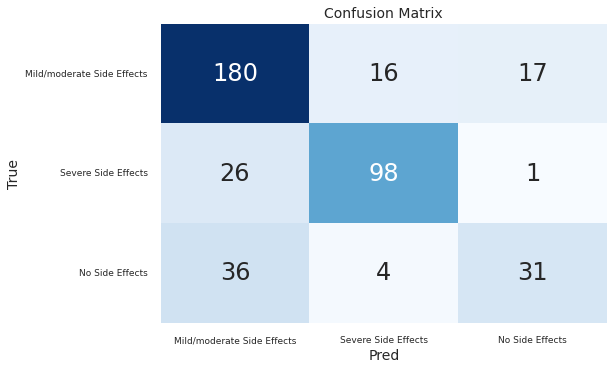

In [ ]:
## Plot confusion matrix
cm = metrics.confusion_matrix(Y_test, test_pred)
fig, ax = plt.subplots()
sns.set(font_scale=2.0) # Adjust to fit
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels= data['sideEffects'].unique(), 
       yticklabels=data['sideEffects'].unique(), title="Confusion matrix")
plt.yticks(rotation=0, fontsize=9)
plt.xticks(rotation=0, fontsize=9)
plt.xlabel('Pred',fontsize=14)
plt.ylabel('True',fontsize=14)
plt.title('Confusion Matrix',fontsize=14)
plt.show()

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(100,50,50,50), 
                      activation='relu',
                      solver='adam',
                      max_iter=500)
model.fit(X_train, Y_train)

start = time.time()
test_pred = model.predict(X_test)
end = time.time()
print('Classification costs:',(end-start), 'seconds')

Classification costs: 0.006046295166015625 seconds


In [ ]:
print('\t\t\t\tCLASSIFICATION METRICS\n')
print(metrics.classification_report(Y_test, test_pred, 
                                    target_names= data['sideEffects'].unique()))

				CLASSIFICATION METRICS

                            precision    recall  f1-score   support

Mild/moderate Side Effects       0.72      0.85      0.78       213
       Severe Side Effects       0.83      0.73      0.78       125
           No Side Effects       0.65      0.42      0.51        71

                  accuracy                           0.74       409
                 macro avg       0.73      0.67      0.69       409
              weighted avg       0.74      0.74      0.73       409



In [ ]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)

start = time.time()
test_pred = model.predict(X_test)
end = time.time()
print('Classification costs:',(end-start), 'seconds')

Classification costs: 0.026891469955444336 seconds


In [ ]:
print('\t\t\t\tCLASSIFICATION METRICS\n')
print(metrics.classification_report(Y_test, test_pred, 
                                    target_names= data['sideEffects'].unique()))

				CLASSIFICATION METRICS

                            precision    recall  f1-score   support

Mild/moderate Side Effects       0.62      0.98      0.76       213
       Severe Side Effects       0.97      0.47      0.63       125
           No Side Effects       0.50      0.07      0.12        71

                  accuracy                           0.67       409
                 macro avg       0.70      0.51      0.51       409
              weighted avg       0.70      0.67      0.61       409



# Clustering

In [50]:
vectorizer = TfidfVectorizer()                                                                       
                                                                                                     
X_stemmed_tfidf = vectorizer.fit_transform(text_stemmed_preprocessed)
X_lemmed_tfidf = vectorizer.fit_transform(text_lemmed_preprocessed)
print(X_stemmed_tfidf.shape)
print(X_lemmed_tfidf.shape)

(4082, 6149)
(4082, 7666)


In [51]:
textXclustering = X_stemmed_tfidf

In [52]:
#reset indexes
clas = data['sideEffects']
clas = clas.reset_index()
clas = clas['sideEffects']
n = len(np.unique(clas))

In [53]:
svd = TSNE(n_components=2, init='random', learning_rate='auto')
data_svd = svd.fit_transform(textXclustering) 
scatter_x = data_svd[:, 0]
scatter_y = data_svd[:, 1]

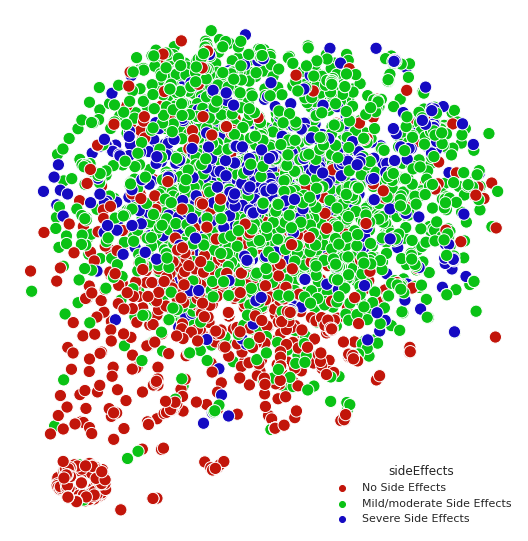

In [54]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.0)
sns.scatterplot(x = scatter_x, y=scatter_y, hue=clas, palette=sns.hls_palette(n, l=.4, s=.9), s=150)
plt.tight_layout()
plt.axis('off')
plt.show()

In [ ]:
# # 3D viz
# svd = TSNE(n_components=3, init='random', learning_rate='auto')
# data_svd = svd.fit_transform(textXclustering) 
# scatter_x = data_svd[:, 0]
# scatter_y = data_svd[:, 1]
# scatter_z = data_svd[:, 2]

In [ ]:
# px.scatter_3d(x=scatter_x, y=scatter_y, z=scatter_z, color=y)

In [55]:
def TSNE_cluster_plot(model):
  clusters = model.labels_ +1
  clusters = clusters.tolist()
  n = len(np.unique(clusters))

  plt.figure(figsize=(8, 8))
  sns.scatterplot(x = scatter_x, y=scatter_y, hue=clusters, palette=sns.hls_palette(n, l=.4, s=.9), s=150)
  plt.tight_layout()
  plt.axis('off')
  plt.show()

### K-means

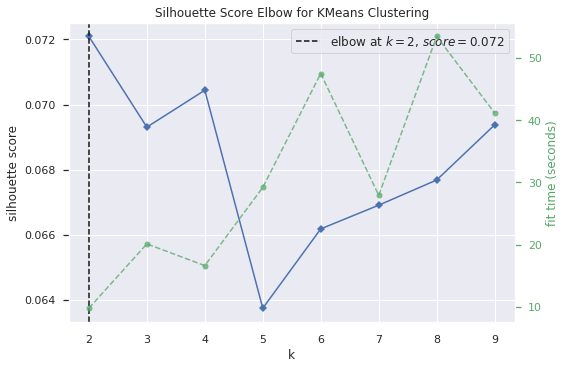

In [ ]:
model = KMeans(random_state=100)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(textXclustering.toarray())
visualizer.show()

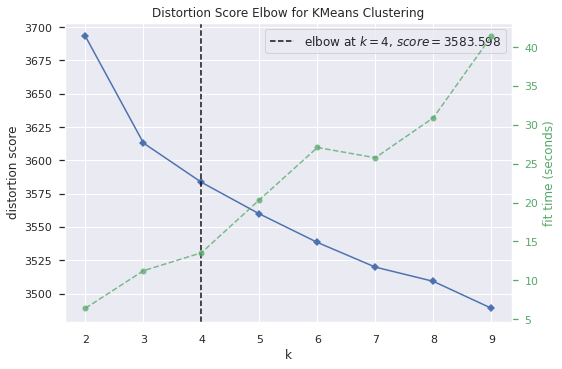

In [ ]:
visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion')

visualizer.fit(textXclustering.toarray())
visualizer.show()

In [56]:
kmeans = KMeans(n_clusters=4, random_state=1, n_init=100)
# Clustering
y_clust= kmeans.fit_predict(textXclustering)

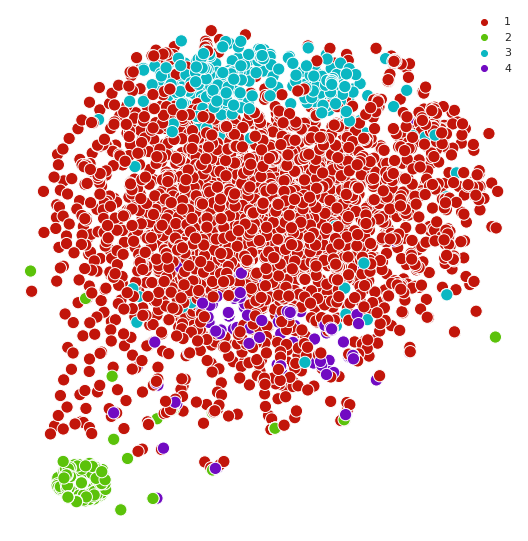

In [57]:
TSNE_cluster_plot(kmeans)

In [ ]:
# Save results
clust = kmeans.labels_ +1
data['kmeans'] = clust.tolist()

In [ ]:
# normalized mutual info_score 
print(normalized_mutual_info_score(data['kmeans'],
                                     data['sideEffects']))

0.20434749428313903


### Agglomerative

In [58]:
Aggmodel = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')

Aggmodel.fit(textXclustering.toarray())

AgglomerativeClustering(linkage='complete', n_clusters=4)

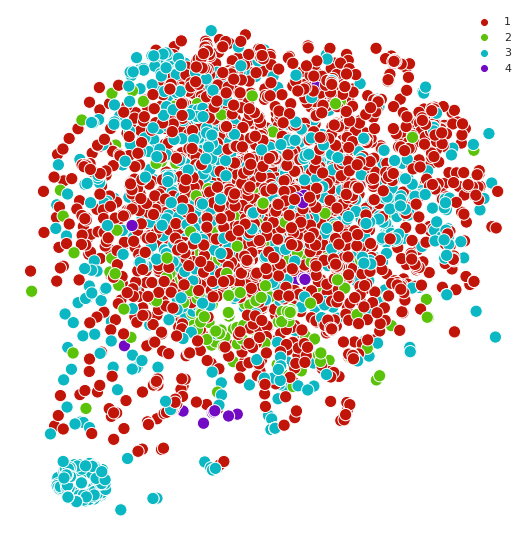

In [59]:
TSNE_cluster_plot(Aggmodel)

### Density-based clustering
+ Can find the right number of clusters
+ Can find clusters with different “shapes”

In [60]:
# Apply DBSCAN
db = DBSCAN(min_samples=100,eps=0.5)
db.fit(textXclustering)

DBSCAN(min_samples=100)

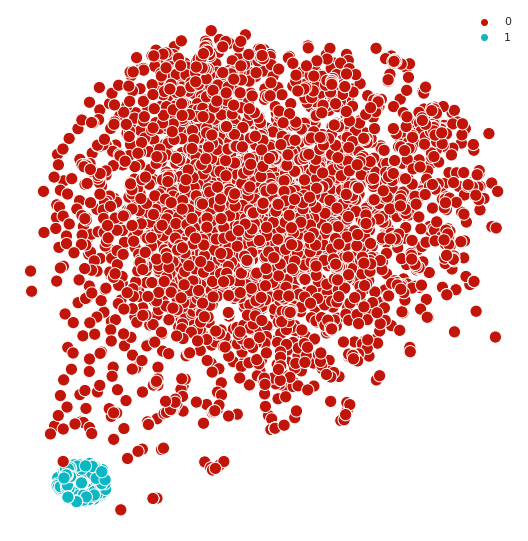

In [61]:
TSNE_cluster_plot(db)

## Evaluation

In [ ]:
def plot_wordcloud(cnt):
  wordcloud = WordCloud(max_font_size = 50,         #-- Font Size
                        max_words = 100,          #-- Mamimum Words
                       background_color = "white") #-- Color Space
  wordcloud.generate_from_frequencies(dict(cnt))
  plt.figure()
  plt.imshow(wordcloud, interpolation = "bilinear")
  plt.axis("off")
  plt.show()

def count_words(text):
  cnt = Counter()
  for sent in text:
    for token in sent:
      if token not in ['br']:
        cnt[token] += 1
  return cnt.most_common()[:50]

### K_means

In [ ]:
dataset_stemmed = pd.DataFrame()
dataset_stemmed['X_stemmed_tfidf_kmeans'] = kmeans.labels_ + 1
dataset_stemmed['stem'] = text_stemmed

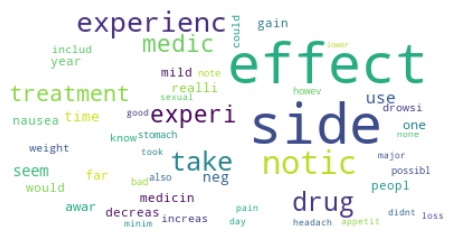

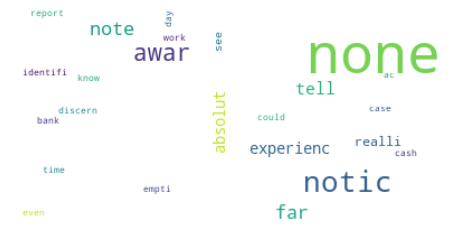

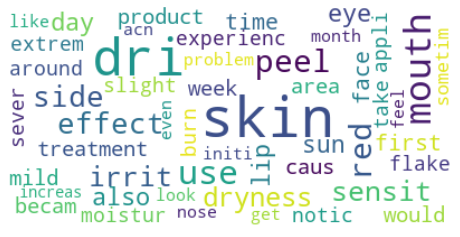

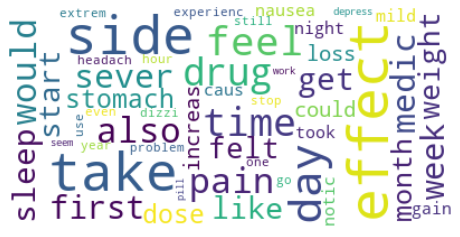

In [ ]:
for i in range(1,len(np.unique(kmeans.labels_))+1):
  temp = dataset_stemmed[dataset_stemmed['X_stemmed_tfidf_kmeans'] == i]['stem']
  cnt = count_words(temp)
  plot_wordcloud(cnt)

### Agglomerative

In [ ]:
dataset_stemmed = pd.DataFrame()
dataset_stemmed['X_stemmed_tfidf_agg'] = Aggmodel.labels_ + 1
dataset_stemmed['stem'] = text_stemmed

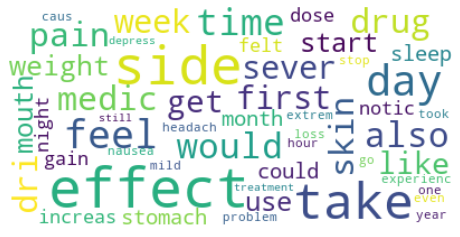

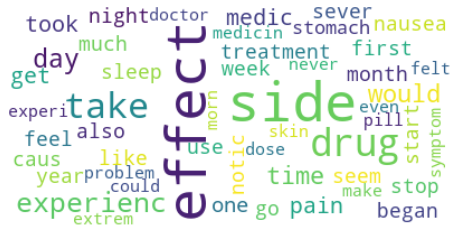

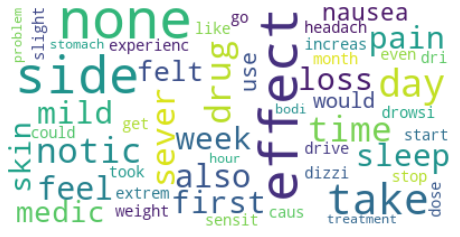

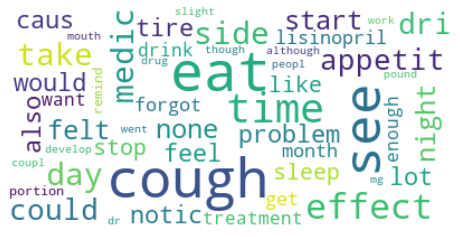

In [ ]:
for i in range(1,len(np.unique(Aggmodel.labels_))+1):
  temp = dataset_stemmed[dataset_stemmed['X_stemmed_tfidf_agg'] == i]['stem']
  cnt = count_words(temp)
  plot_wordcloud(cnt)

### Density-based

In [ ]:
dataset_stemmed = pd.DataFrame()
dataset_stemmed['X_stemmed_tfidf_db'] = db.labels_ + 1
dataset_stemmed['stem'] = text_lemmed

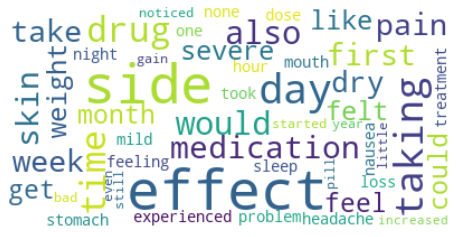

In [ ]:
temp = dataset_stemmed[dataset_stemmed['X_stemmed_tfidf_db'] == 0]['stem']
cnt = count_words(temp) 
plot_wordcloud(cnt)

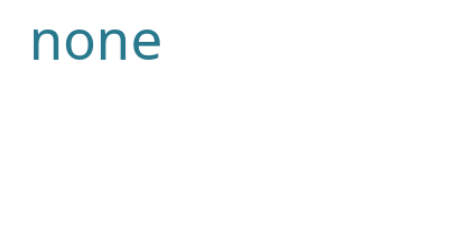

In [ ]:
temp = dataset_stemmed[dataset_stemmed['X_stemmed_tfidf_db'] == 1]['stem']
cnt = count_words(temp) 
plot_wordcloud(cnt)

## Istogrammi

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=1, n_init=100)
y_clust= kmeans.fit_predict(textXclustering)

In [ ]:
Counter(kmeans.labels_+1)

Counter({1: 3131, 2: 345, 3: 344, 4: 262})

In [ ]:
etichette_kmeans=kmeans.labels_+1

### sideEffects

In [ ]:
df_aux=pd.DataFrame()
df_aux['sideEffects']=data['sideEffects']
df_aux['label']=etichette_kmeans
df_aux

,sideEffects,label
0,Mild/moderate Side Effects,1
1,Severe Side Effects,1
2,No Side Effects,1
3,Mild/moderate Side Effects,3
4,Severe Side Effects,1
...,...,...
4138,Severe Side Effects,1
4139,No Side Effects,4
4140,Mild/moderate Side Effects,1
4141,No Side Effects,1


In [ ]:
df_aux.groupby(['sideEffects','label']).size()

sideEffects                 label
No Side Effects             1         600
                            2         327
                            3          12
                            4         239
Mild/moderate Side Effects  1        1834
                            2          17
                            3         295
                            4          21
Severe Side Effects         1         697
                            2           1
                            3          37
                            4           2
dtype: int64

In [ ]:
df_count=pd.DataFrame({'count' : df_aux.groupby( ['sideEffects','label']).size()}).reset_index()
df_count

,sideEffects,label,count
0,No Side Effects,1,600
1,No Side Effects,2,327
2,No Side Effects,3,12
3,No Side Effects,4,239
4,Mild/moderate Side Effects,1,1834
5,Mild/moderate Side Effects,2,17
6,Mild/moderate Side Effects,3,295
7,Mild/moderate Side Effects,4,21
8,Severe Side Effects,1,697
9,Severe Side Effects,2,1


In [ ]:
df_count_wide=df_count.pivot(index='label', columns='sideEffects', values='count')#.reset_index()
df_count_wide.columns=df_count_wide.columns.tolist()
df_count_wide=df_count_wide.reset_index()
df_count_wide

,label,No Side Effects,Mild/moderate Side Effects,Severe Side Effects
0,1,600,1834,697
1,2,327,17,1
2,3,12,295,37
3,4,239,21,2


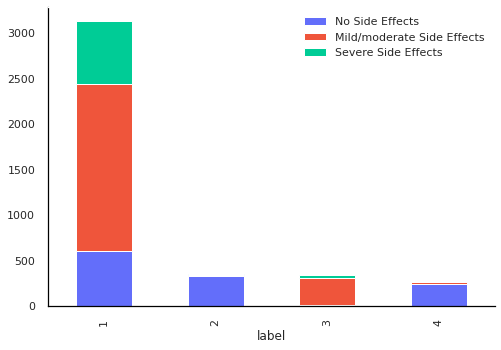

In [ ]:
# plot data in stack manner of bar type
x=df_count_wide.plot(x='label', kind='bar', stacked=True, color=px.colors.qualitative.Plotly)
        #title='Stacked Bar Graph by dataframe')
x.set_facecolor('white')
x.spines['bottom'].set_color('black')
x.spines['left'].set_color('black')

In [ ]:
df_count_wide=df_count.pivot(index='label', columns='sideEffects', values='count')
df_count_wide.columns=df_count_wide.columns.tolist()
df_count_wide=df_count_wide.reset_index()
df_count_wide["sum"] = df_count_wide.sum(axis=1)
df_new=df_count_wide.loc[:,'No Side Effects':'Severe Side Effects'].div(df_count_wide['sum'],axis=0)
df_new['label']=df_count_wide['label']
df_new

,No Side Effects,Mild/moderate Side Effects,Severe Side Effects,label
0,0.191571,0.585568,0.222542,1
1,0.942363,0.048991,0.002882,2
2,0.034582,0.850144,0.106628,3
3,0.898496,0.078947,0.007519,4


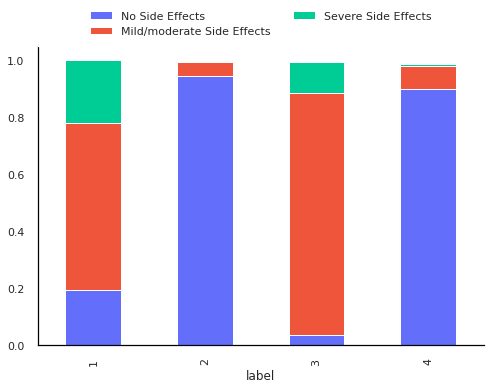

In [ ]:
# plot data in stack manner of bar type
x=df_new.plot(x='label', kind='bar', stacked=True, color=px.colors.qualitative.Plotly);plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)
        #title='Stacked Bar Graph by dataframe')
x.set_facecolor('white')
x.spines['bottom'].set_color('black')
x.spines['left'].set_color('black')

### rating

In [ ]:
df_aux=pd.DataFrame()
df_aux['rating']=data['rating']
df_aux['label']=etichette_kmeans
df_aux

,rating,label
0,low,1
1,low,1
2,high,1
3,low,3
4,low,1
...,...,...
4138,medium,1
4139,high,4
4140,medium,1
4141,high,1


In [ ]:
df_aux.groupby(['rating','label']).size()

rating  label
low     1         800
        2          20
        3          55
        4          17
medium  1        1302
        2          93
        3         166
        4          66
high    1        1029
        2         232
        3         123
        4         179
dtype: int64

In [ ]:
df_count=pd.DataFrame({'count' : df_aux.groupby( ['rating','label']).size()}).reset_index()
df_count

,rating,label,count
0,low,1,800
1,low,2,20
2,low,3,55
3,low,4,17
4,medium,1,1302
5,medium,2,93
6,medium,3,166
7,medium,4,66
8,high,1,1029
9,high,2,232


In [ ]:
df_count_wide=df_count.pivot(index='label', columns='rating', values='count')#.reset_index()
df_count_wide.columns=df_count_wide.columns.tolist()
df_count_wide=df_count_wide.reset_index()
df_count_wide

,label,low,medium,high
0,1,800,1302,1029
1,2,20,93,232
2,3,55,166,123
3,4,17,66,179


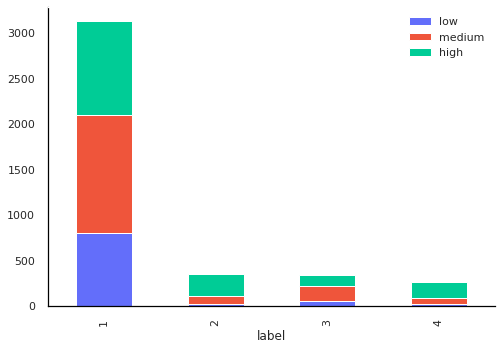

In [ ]:
# plot data in stack manner of bar type
x=df_count_wide.plot(x='label', kind='bar', stacked=True, color=px.colors.qualitative.Plotly)
        #title='Stacked Bar Graph by dataframe')
x.set_facecolor('white')
x.spines['bottom'].set_color('black')
x.spines['left'].set_color('black')

### effectiveness

In [ ]:
df_aux=pd.DataFrame()
df_aux['effectiveness']=data['effectiveness']
df_aux['label']=etichette_kmeans
df_aux

,effectiveness,label
0,Highly Effective,1
1,Highly Effective,1
2,Highly Effective,1
3,Marginally Effective,3
4,Marginally Effective,1
...,...,...
4138,Considerably Effective,1
4139,Highly Effective,4
4140,Considerably Effective,1
4141,Highly Effective,1


In [ ]:
df_aux.groupby(['effectiveness','label']).size()

effectiveness           label
Ineffective             1         291
                        2          11
                        3          16
                        4           9
Marginally Effective    1         207
                        2          16
                        3          28
                        4           7
Moderately Effective    1         458
                        2          26
                        3          59
                        4          19
Considerably Effective  1         937
                        2          88
                        3         113
                        4          77
Highly Effective        1        1238
                        2         204
                        3         128
                        4         150
dtype: int64

In [ ]:
df_count=pd.DataFrame({'count' : df_aux.groupby( ['effectiveness','label']).size()}).reset_index()
df_count

,effectiveness,label,count
0,Ineffective,1,291
1,Ineffective,2,11
2,Ineffective,3,16
3,Ineffective,4,9
4,Marginally Effective,1,207
5,Marginally Effective,2,16
6,Marginally Effective,3,28
7,Marginally Effective,4,7
8,Moderately Effective,1,458
9,Moderately Effective,2,26


In [ ]:
df_count_wide=df_count.pivot(index='label', columns='effectiveness', values='count')#.reset_index()
df_count_wide.columns=df_count_wide.columns.tolist()
df_count_wide=df_count_wide.reset_index()
df_count_wide

,label,Ineffective,Marginally Effective,Moderately Effective,Considerably Effective,Highly Effective
0,1,291,207,458,937,1238
1,2,11,16,26,88,204
2,3,16,28,59,113,128
3,4,9,7,19,77,150


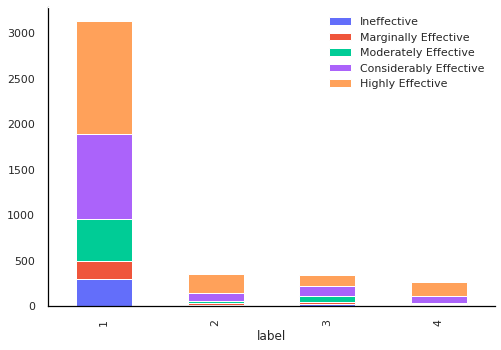

In [ ]:
# plot data in stack manner of bar type
x=df_count_wide.plot(x='label', kind='bar', stacked=True, color=px.colors.qualitative.Plotly)
        #title='Stacked Bar Graph by dataframe')
x.set_facecolor('white')
x.spines['bottom'].set_color('black')
x.spines['left'].set_color('black')

### drugs

In [ ]:
df_drugs=pd.DataFrame(data.groupby('urlDrugName').size())
drugs_list=[ "retin-a" , "lezapro", "accutane" , "chantix", "topamax", "seroquel", "retin-a-micro", "renova", "zovirax", "armour-thyroid","sotret"]
#drugs=df_drugs[df_drugs[0].isin(range(45,80))].index.tolist() 
drugs=df_drugs[df_drugs.index.isin(drugs_list)].index.tolist() 
drugs

['accutane',
 'armour-thyroid',
 'chantix',
 'renova',
 'retin-a',
 'retin-a-micro',
 'seroquel',
 'sotret',
 'topamax',
 'zovirax']

In [ ]:
df_aux=pd.DataFrame()
df_aux['drugName']=data['urlDrugName']
df_aux['label']=etichette_kmeans
df_aux = df_aux[df_aux['drugName'].isin(drugs)]

In [ ]:
df_aux.groupby(['drugName','label']).size()

drugName        label
accutane        1        10
                2         1
                3        33
armour-thyroid  1         6
                2         7
                4         1
chantix         1        43
                4         1
renova          1        13
                2         1
                3        19
retin-a         1        18
                3        34
retin-a-micro   1        11
                3        19
seroquel        1        31
                3         1
sotret          1         3
                3         7
topamax         1        34
                4         1
zovirax         1         4
                2         5
                4         3
dtype: int64

In [ ]:
df_count=pd.DataFrame({'count' : df_aux.groupby( ['drugName','label']).size()}).reset_index()

In [ ]:
df_count_wide=df_count.pivot(index='label', columns='drugName', values='count')#.reset_index()
df_count_wide.columns=df_count_wide.columns.tolist()
df_count_wide=df_count_wide.reset_index()
df_count_wide

,label,accutane,armour-thyroid,chantix,renova,retin-a,retin-a-micro,seroquel,sotret,topamax,zovirax
0,1,10.0,6.0,43.0,13.0,18.0,11.0,31.0,3.0,34.0,4.0
1,2,1.0,7.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,5.0
2,3,33.0,NaN,NaN,19.0,34.0,19.0,1.0,7.0,NaN,NaN
3,4,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,3.0


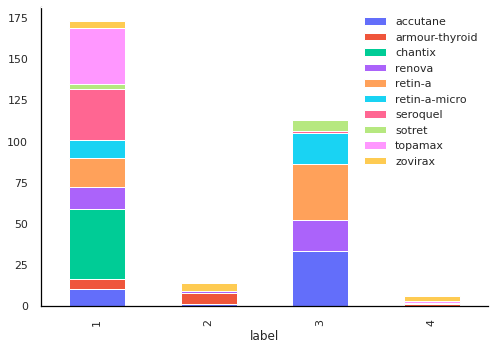

In [ ]:
# plot data in stack manner of bar type
x=df_count_wide.plot(x='label', kind='bar', stacked=True, color=px.colors.qualitative.Plotly)
        #title='Stacked Bar Graph by dataframe')
x.set_facecolor('white')
x.spines['bottom'].set_color('black')
x.spines['left'].set_color('black')

In [ ]:
df_count_wide=df_count.pivot(index='drugName', columns='label', values='count')#.reset_index()
df_count_wide.columns=df_count_wide.columns.tolist()
df_count_wide=df_count_wide.reset_index()
df_count_wide.replace(np.nan, 0,inplace=True)
df_count_wide["sum"] = df_count_wide.sum(axis=1)
df_new=df_count_wide.loc[:,1:4].div(df_count_wide['sum'],axis=0)
df_new['drugName']=df_count_wide['drugName']
df_new

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


,1,2,3,4,drugName
0,0.227273,0.022727,0.750000,0.000000,accutane
1,0.428571,0.500000,0.000000,0.071429,armour-thyroid
2,0.977273,0.000000,0.000000,0.022727,chantix
3,0.393939,0.030303,0.575758,0.000000,renova
4,0.346154,0.000000,0.653846,0.000000,retin-a
5,0.366667,0.000000,0.633333,0.000000,retin-a-micro
6,0.968750,0.000000,0.031250,0.000000,seroquel
7,0.300000,0.000000,0.700000,0.000000,sotret
8,0.971429,0.000000,0.000000,0.028571,topamax
9,0.333333,0.416667,0.000000,0.250000,zovirax


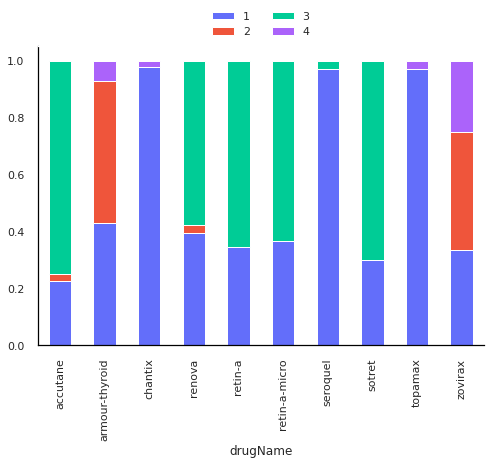

In [ ]:
# plot data in stack manner of bar type
x=df_new.plot(x='drugName', kind='bar', stacked=True, color=px.colors.qualitative.Plotly);plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)

x.set_facecolor('white')
x.spines['bottom'].set_color('black')
x.spines['left'].set_color('black')

### drugs case (retin-a)

In [ ]:
dataset_stemmed = pd.DataFrame()
dataset_stemmed['X_stemmed_tfidf_kmeans'] = kmeans.labels_ + 1
dataset_stemmed['lem'] = text_stemmed
dataset_stemmed['drugName']=data['urlDrugName']
dataset_stemmed_retina=dataset_stemmed[dataset_stemmed['drugName']=='retin-a']

In [ ]:
dataset_stemmed_retina

,X_stemmed_tfidf_kmeans,lem,drugName
168,1,"[medic, made, tire, soon, take, medic, fell, a...",retin-a
206,1,"[side, effect, includ, slightli, lower, sex, d...",retin-a
241,3,"[take, highest, dosag, period, year, medic, se...",retin-a
320,1,"[side, effect, minim, would, feel, tiredlethar...",retin-a
505,1,"[could, sleep, night, would, fall, asleep, day...",retin-a
519,1,"[two, dose, infliximab, four, week, period, ne...",retin-a
618,1,"[advers, side, effect, medic, state, take, foo...",retin-a
655,1,"[side, effect, feel, tired, lower, libido, sid...",retin-a
840,1,"[seroquel, hangovercomedown, everyday, feel, s...",retin-a
971,1,"[diarrhea, first, coupl, mo, bodi, acclim, sul...",retin-a


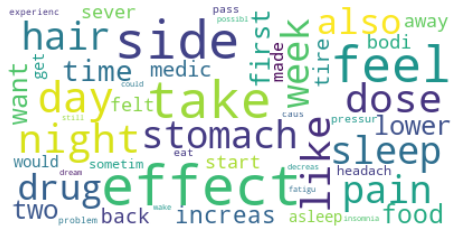

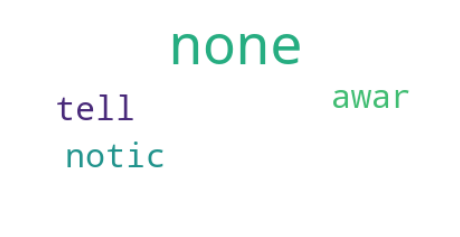

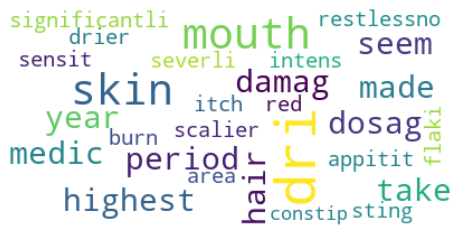

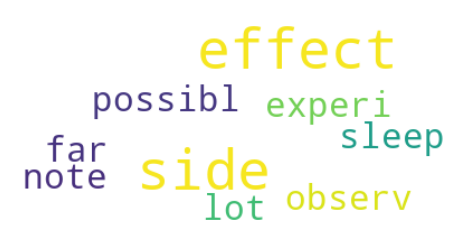

In [ ]:
for i in range(1,len(np.unique(kmeans.labels_))+1):
  temp = dataset_stemmed_retina[dataset_stemmed_retina['X_stemmed_tfidf_kmeans'] == i]['lem']
  cnt = count_words(temp)
  plot_wordcloud(cnt)